In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
from pandas import read_csv
import datetime
from pandas import concat
import numpy as np
# load data
def parse(x):
	return datetime.datetime.strptime(x, '%Y %m %d %H')

dataset = []
for i in range(10,29):
	dataset.append(read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_202208' + str(i) +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))
for i in range(1,10):
	dataset.append(read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_2022080' + str(i) +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))

dataset = concat([dataset[i] for i in range(len(dataset))], axis=0)
dataset.drop('No', axis=1, inplace=True) 
# manually specify column names
dataset.columns = ['local', 'temp', 'humidity', 'metter']
dataset.index.name = 'date'
# mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5)) 
# save to file
dataset.to_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv')
print(dataset)


                     local  temp  humidity  metter
date                                              
2022-08-10 09:00:00      1  16.5      59.3       1
2022-08-10 09:00:00      2  16.6      59.3       1
2022-08-10 09:00:00      3  16.4      58.8       2
2022-08-10 09:00:00      4  16.9      56.7       1
2022-08-10 09:00:00      5  16.2      57.3       0
                     local  temp  humidity  metter
date                                              
2022-08-10 09:00:00      1  16.5      59.3       1
2022-08-10 09:00:00      2  16.6      59.3       1
2022-08-10 09:00:00      3  16.4      58.8       2
2022-08-10 09:00:00      4  16.9      56.7       1
2022-08-10 09:00:00      5  16.2      57.3       0
...                    ...   ...       ...     ...
2022-08-09 21:00:00      2  20.5      57.0       1
2022-08-09 21:00:00      3  19.2      55.4       0
2022-08-09 21:00:00      4  18.5      54.0       0
2022-08-09 21:00:00      5  19.4      55.5       1
2022-08-09 21:00:00      6  19.

성능이 잘 안나와서 3D로 예측하려 함

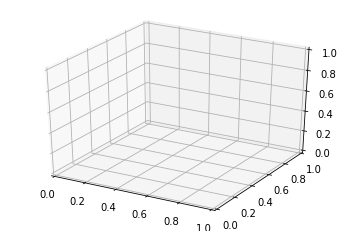

In [33]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

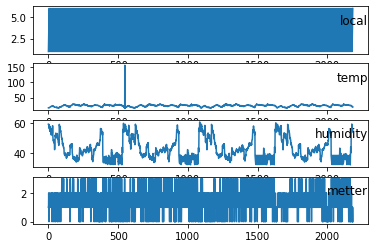

In [34]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [36]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	# print(df)
	cols, names = list(), list()
	# 7일 전의 환경 데이터를 input, 7일 후의 환경 데이터를 target으로 설정
	cols.append(df.shift(6*13*7))
	names += [('var%d(t-%d)' % (j+1, 7)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	cols.append(df)
	names += [('var%d(t)' % (j+1)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	# drop columns we don't want to predict
	agg.drop(agg.columns[[3,4]], axis=1, inplace=True)
	
	# 구역에 따라  환경데이터를 묶어준다.

	local = agg[['var1(t-7)',  'var2(t-7)',  'var3(t-7)']].values
	local = local.reshape(13*7*3,6,3)

	label = agg['var3(t)'].values.reshape(13*7*3,6)

	return local, label

# load dataset

dataset = read_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv', header=0, index_col=0)
values = dataset.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed, target = series_to_supervised(scaled, 1, 1)
print(reframed.shape, target.shape)

(273, 6, 3) (273, 6)


In [37]:
# split into train and test sets
values = reframed
# 5일치를 학습시킴
n_train_hours = 13*7*2
train_X, train_y = values[:n_train_hours], target[:n_train_hours]
test_X,  test_y  = values[n_train_hours:], target[n_train_hours:]

# split into input and outputs

# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(182, 6, 3) (182, 6) (91, 6, 3) (91, 6)


Epoch 1/65
31/31 - 2s - loss: 0.4449 - accuracy: 0.7143 - val_loss: 0.3514 - val_accuracy: 0.8352 - 2s/epoch - 63ms/step
Epoch 2/65
31/31 - 0s - loss: 0.2983 - accuracy: 0.7912 - val_loss: 0.2294 - val_accuracy: 0.8352 - 170ms/epoch - 5ms/step
Epoch 3/65
31/31 - 0s - loss: 0.2119 - accuracy: 0.7912 - val_loss: 0.1787 - val_accuracy: 0.8352 - 174ms/epoch - 6ms/step
Epoch 4/65
31/31 - 0s - loss: 0.1838 - accuracy: 0.7912 - val_loss: 0.1774 - val_accuracy: 0.8352 - 222ms/epoch - 7ms/step
Epoch 5/65
31/31 - 0s - loss: 0.1801 - accuracy: 0.7912 - val_loss: 0.1769 - val_accuracy: 0.8352 - 211ms/epoch - 7ms/step
Epoch 6/65
31/31 - 0s - loss: 0.1801 - accuracy: 0.7912 - val_loss: 0.1728 - val_accuracy: 0.8352 - 227ms/epoch - 7ms/step
Epoch 7/65
31/31 - 0s - loss: 0.1775 - accuracy: 0.7912 - val_loss: 0.1716 - val_accuracy: 0.8352 - 242ms/epoch - 8ms/step
Epoch 8/65
31/31 - 0s - loss: 0.1762 - accuracy: 0.7912 - val_loss: 0.1713 - val_accuracy: 0.8352 - 222ms/epoch - 7ms/step
Epoch 9/65
31/31 -

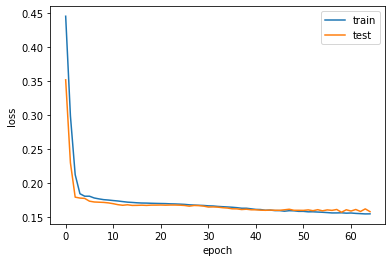

In [50]:

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import BatchNormalization


# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2]), activation="softsign", recurrent_activation="elu"))
model.add(Dense(12))
model.add(Dense(8))
model.add(Dense(6))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=65 , batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False, validation_split = 0.1)
# plot historyz
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
from sklearn.metrics import mean_squared_error
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0]*test_X.shape[1], test_X.shape[2]))
# yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
# print(test_X.shape, yhat.shape)

# # invert scaling for forecast
# inv_yhat = np.concatenate(( test_X[:,:-1],yhat), axis = 1)
# print(inv_yhat.shape)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,-1]
# # invert scaling for actual

# test_y = test_y.reshape(test_y.shape[0]*test_y.shape[1], 1)
# inv_y = np.concatenate((test_X[:,:-1], test_y), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,-1]

prediction = model.predict(test_X)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, prediction))
print('Test RMSE: %.3f' % rmse)

loss, acc = model.evaluate(test_X, test_y, batch_size=1)
print("loss : ", loss)
print("acc : " , acc)

# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_y, prediction)
print("R2 : ", r2_y_predict)

3/3 [==============================] - 0s 6ms/step
Test RMSE: 0.212
91/91 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.8132
loss :  0.15739251673221588
acc :  0.8131868243217468
R2 :  0.26349973970682034


In [85]:

# 다음 날의 주행을 예측하기 위해서는 현재로부터 6일 전의 데이터를 넣고 추출시켜야 함
tst_tim = str(datetime.datetime.now() - datetime.timedelta(days = 6))
tst_tim = tst_tim[:tst_tim.find(' ')].replace('-', '')
print(tst_tim)
predic_data = []
predic_data.append(read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_' + tst_tim +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))


predic_data = concat([predic_data[i] for i in range(len(predic_data))], axis=0)
predic_data.drop('No', axis=1, inplace=True) 
# manually specify column names
predic_data.columns = ['local', 'temp', 'humidity', 'metter']
predic_data.index.name = 'date'

print(predic_data.head(5)) 

predic_values = predic_data.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
predic_values = predic_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
predic_scaled = scaler.fit_transform(predic_values)
# frame as supervised learning
predic_scaled = predic_scaled.reshape(13,6,3)
predic = np.array(model.predict(predic_scaled))
print(predic_scaled)

20220812
                     local  temp  humidity  metter
date                                              
2022-08-12 09:00:00      1  23.3      45.3       3
2022-08-12 09:00:00      2  23.4      44.4       3
2022-08-12 09:00:00      3  23.5      44.0       2
2022-08-12 09:00:00      4  22.8      43.8       2
2022-08-12 09:00:00      5  23.1      45.8       1
1/1 [==============================] - 0s 40ms/step
[[[0.18571424 0.92622924 1.        ]
  [0.19999981 0.85245895 1.        ]
  [0.21428561 0.81967187 0.6666667 ]
  [0.11428547 0.80327845 0.6666667 ]
  [0.15714288 0.9672129  0.33333334]
  [0.14285707 0.8852458  0.33333334]]

 [[0.17142868 0.77868843 0.6666667 ]
  [0.19999981 0.77868843 0.6666667 ]
  [0.35714293 0.9426229  0.33333334]
  [0.39999986 0.9344263  0.33333334]
  [0.32857132 0.8770492  0.33333334]
  [0.37142873 0.9672129  0.6666667 ]]

 [[0.45714307 0.86885214 0.6666667 ]
  [0.45714307 1.         0.33333334]
  [0.45714307 0.9016392  0.33333334]
  [0.6428571  0.4999997

# 정화 시간 match
- softmax 함수를 구현
- predict로 구한 다음 날의 오염도를 sftmax함수에 넣고 주행 시간 구하기

In [60]:
#softmax function 
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

In [61]:
# sults clean_time
clean_time = np.array([])
local = np.array([])
for i in predic:
  clean_time = np.append(clean_time, [int(round(i)) for i in (softmax(i)*60)])
  local = np.append(local, np.arange(1,7))
clean_time = clean_time.reshape(clean_time.shape[0],1)
local      = local.reshape(local.shape[0],1)
scadul     = np.concatenate((local, clean_time), axis = 1)
columns    = [ 'local', 'stay_time']
send_df    = DataFrame(scadul, columns = columns)
send_df    = send_df.set_index('local')
print(send_df)
send_df.to_csv('/content/drive/MyDrive/dataset/pollution_data/send.csv')

       stay_time
local           
1.0         15.0
2.0         10.0
3.0          9.0
4.0         12.0
5.0          7.0
...          ...
2.0         12.0
3.0         11.0
4.0          8.0
5.0          8.0
6.0          9.0

[78 rows x 1 columns]


In [95]:
# compare prediction and db
tomorrow_time = str(datetime.datetime.now() + datetime.timedelta(days = 1))
tomorrow_time = tomorrow_time[:tomorrow_time.find(' ')].replace('-', '')
tomorrow_data=np.array([])
tomorrow_data = np.append(tomorrow_data,read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_' + tomorrow_time +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)['metter'].values)

real_clean_time = np.array([])
for i in predic:
  real_clean_time = np.append(real_clean_time, [int(round(i)) for i in (softmax(i)*60)])
  
real_clean_time = real_clean_time.reshape(real_clean_time.shape[0],1)
rmse = np.sqrt(mean_squared_error(real_clean_time, clean_time))

#예측 결과 100% 맞음
#다만, 현재 예측한 결과는 train_data에 이미 있는 값임
time = np.concatenate((real_clean_time, clean_time), axis = 1)
print(time)
print('Test RMSE: %.3f' % rmse)


[[15. 15.]
 [10. 10.]
 [ 9.  9.]
 [12. 12.]
 [ 7.  7.]
 [ 7.  7.]
 [14. 14.]
 [10. 10.]
 [ 9.  9.]
 [ 9.  9.]
 [ 9.  9.]
 [10. 10.]
 [13. 13.]
 [ 8.  8.]
 [ 8.  8.]
 [11. 11.]
 [ 9.  9.]
 [10. 10.]
 [15. 15.]
 [13. 13.]
 [12. 12.]
 [ 8.  8.]
 [ 7.  7.]
 [ 6.  6.]
 [16. 16.]
 [11. 11.]
 [10. 10.]
 [12. 12.]
 [ 6.  6.]
 [ 7.  7.]
 [15. 15.]
 [12. 12.]
 [11. 11.]
 [ 8.  8.]
 [ 7.  7.]
 [ 8.  8.]
 [13. 13.]
 [11. 11.]
 [11. 11.]
 [ 8.  8.]
 [ 8.  8.]
 [ 8.  8.]
 [14. 14.]
 [11. 11.]
 [11. 11.]
 [ 8.  8.]
 [ 7.  7.]
 [ 8.  8.]
 [14. 14.]
 [11. 11.]
 [11. 11.]
 [ 8.  8.]
 [ 8.  8.]
 [ 8.  8.]
 [15. 15.]
 [10. 10.]
 [10. 10.]
 [11. 11.]
 [ 7.  7.]
 [ 8.  8.]
 [13. 13.]
 [11. 11.]
 [11. 11.]
 [ 8.  8.]
 [ 9.  9.]
 [ 8.  8.]
 [13. 13.]
 [12. 12.]
 [11. 11.]
 [ 9.  9.]
 [ 7.  7.]
 [ 8.  8.]
 [12. 12.]
 [12. 12.]
 [11. 11.]
 [ 8.  8.]
 [ 8.  8.]
 [ 9.  9.]]
Test RMSE: 0.000
